[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SPY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


0
0
Index(['MACD_HIST', 'MFI', 'BB', 'RSI', 'Target'], dtype='object', name='Price')


ValueError: zero-size array to reduction operation maximum which has no identity

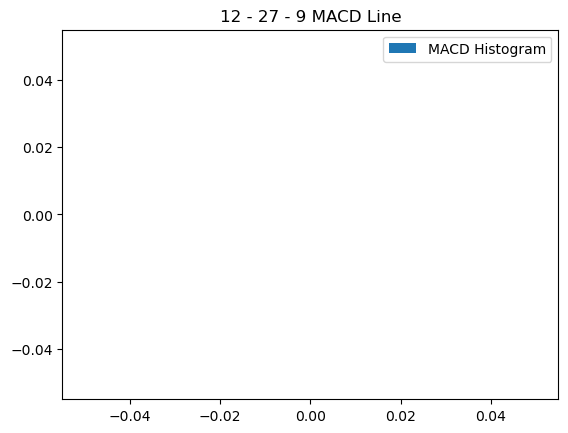

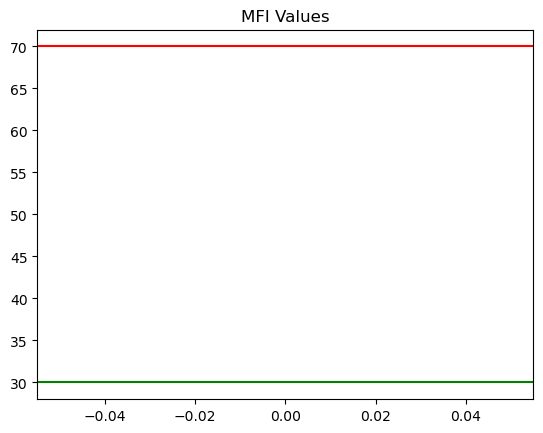

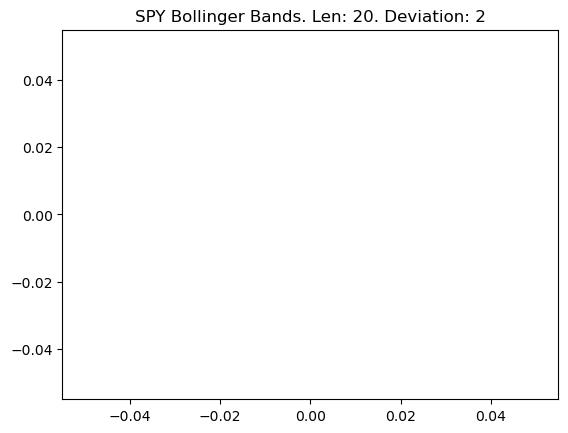

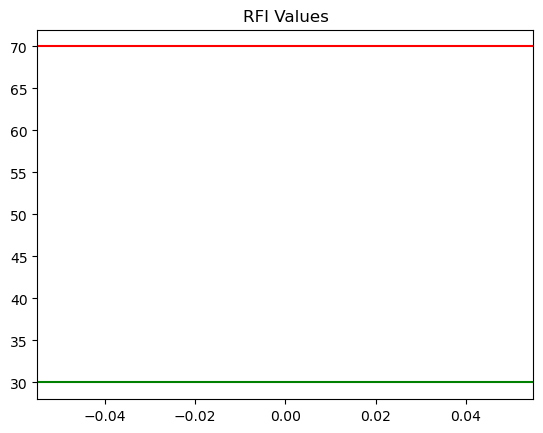

In [2]:
# Switching from SciKit Learn Lib to Stats Models Lib for cleaner results

import numpy as np 
import pandas as pd
from pandas.plotting import lag_plot
import yfinance as yf
import matplotlib.pyplot as plt
    # p-Value is better acessible in this library 
import statsmodels.api as sm

# --- (0) GLOBALEN PARAMETERS ---

# Schritt 1: Ticker
TICKER = "SPY"

# Schritt 2: Preisverhalten 
INTERVAL = "1d"
if INTERVAL == "1h":
    PERIOD = "730d"
else: 
    PERIOD = "max"

# Schritt 3: Strategie/Unabhängige Variable (FGV)
STRATEGY = ["MACD_HIST", "MFI", "BB", "RSI"]

#   MACD
MACD_FAST = 12
MACD_SLOW = 27
MACD_SPAN = 9

#   MFI
MFI_LENGTH = 14 
OVERBROUGHT = 70
OVERSOLD = 30 

#   BB
BB_LENGTH = 20
STD_DEV = 2

#   RSI
RSI_LENGTH = 14
RSI_OVERBROUGHT = 70
RSI_OVERSOLD = 30

#   FVG is bullshit, so we do not use it 

# Schritt 4: Verschieben von Reihen in der Vergangenheit
SHIFT = 5
# (INTERVAL =)Can we place a 5h chart using those indicators and accurately forecast price movements as percentage 

# Verbindung der SHIFT-Variablen, in Ihrem Code verwenden Sie SHIFT = 10 für zwei verschiedene Zwecke:
#   In add_target: Es definiert, wie weit in die Zukunft Sie schauen (Close in 10 Perioden minus Close heute).
#       Sinn: Sie versuchen, die Preisänderung über die nächsten 10 Perioden vorherzusagen.
#   In fix_autocorrelation: Es definiert die Abtastfrequenz (Down-Sampling).
#       Sinn: Da Sie über 10 Perioden vorhersagen, filtern Sie die Daten so, dass sich die Zielperioden nicht überlappen und die Beobachtungen unabhängig bleiben.

# Schritt 5: Datenteilmenge (Wie viele Zeilen werden wir analysieren)
LOOKBACK = 10000

# --- (1) Daten herunterladen in df ---

def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):

    # Step 1: Daten herunterladen
    df = yf.download(ticker, interval = interval, period = PERIOD)

    # Step 2: Nur Level 0 of Multilevel Columns selecten
    df.columns = df.columns.get_level_values(0)

    # Step 3: df for Plots vereinfachen (Index statt Datum)
    df = df.reset_index(drop=True)

    # Step 4: Nur LOOKBACK Reihen zurückgeben
    return df.iloc[-lookback:, :]

# --- (2) Unabhängige Variablen ("Features") definieren ---

def add_MACD(df, fast = MACD_FAST, slow = MACD_SLOW, span = MACD_SPAN):

    # Step 1: Fast and Slow EMA Columns
    df[f"{fast}_ema"] = df["Close"].ewm(span = fast).mean()
    df[f"{slow}_ema"] = df["Close"].ewm(span = slow).mean()

    # Step 2: MACD Column (= Difference betwenn fast and slow ema)
    df["MACD"] = df[f"{fast}_ema"] - df[f"{slow}_ema"]

    # Step 3: MACD Signal (= Span Period)
    df["Signal"] = df[f"MACD"].ewm(span = span).mean()

    # Step 4: MACD Hist
    df["MACD_HIST"] = df[f"MACD"] - df["Signal"]

    # Step 5: Plot Histogram
    plt.figure()
    plt.bar(x=range(len(df)), height=df["MACD_HIST"])
        # Every Bar = Every Date in the Index
        # Direction: Bar (>0) --> Bullish vs. Bar (<0) --> Bearish
        # Strength: Bar (Tall) --> Strong Momentum vs. Bar (Short) --> Weak Momentum
    plt.title(f"{MACD_FAST} - {MACD_SLOW} - {MACD_SPAN} MACD Line")
    plt.legend(["MACD Histogram"])

    return df

def add_MFI(df, length = MFI_LENGTH):
        # Step 1: Build the MFI Index
    df["Average_Price"] = (df["High"]+df["Low"]+df["Close"])/3
    df["Money_Flow"] = df["Volume"]*df["Average_Price"]
    # 14 Period Positive & Negative Money Flow
    df["Pos_Flow"] = np.where(df["Average_Price"].diff()>0, df["Average_Price"], 0)
        # diff() == Delta == Change in Prices from One Day to the next
    df["Neg_Flow"] = np.where(df["Average_Price"].diff()<0, df["Average_Price"], 0)
    # Money Flow Ratio - Rolling Average 
    df["MFR"] = df["Pos_Flow"].rolling(window=length).sum() / df["Neg_Flow"].rolling(window=length).sum()
    df["MFI"] = (100 - 100 / (1 + df["MFR"]))

        # Step 2: Plot the MFI Index
    plt.figure()
    plt.plot(df["MFI"])
    plt.title("MFI Values")

        # Step 3: Draw Overbought & Oversold lines
    plt.axhline(OVERBROUGHT, color="red")
    # When the indicator line is above the red line --> asset overbought/overvalued     
    # Short Signal (Sell) triggered when the indicator line crosses above the red line
    plt.axhline(OVERSOLD, color="green")
    # When the indicator line is below this green line --> asset oversold/undervalued 
    # Long Signal (Buy) triggered when the indicator line crosses above the green line

    return df.dropna()

def add_BB(df, std_dev = STD_DEV, length = BB_LENGTH):

    # Step 1: Middle Bend Column
    df["BB_SMA"] = df["Close"].rolling(window=length).mean()
        # rolling(window=length): it takes the Close price and creates a moving window of length periods
        # mean(): it calculates the average price within that window at each step

    # Step 2: Std Deviation Column
    df["BB_STD"] = df["Close"].rolling(window=length).std()
        # std. dev/volatility: quantifies how spread out/ inconsistent your data is. 
        # It measures the average distance of each data point from the mean of the entire set

    # Step 3: Upper Band
    df["Upper Band"] = df["BB_SMA"] + (std_dev * df["BB_STD"])
        # It takes the middle band's value and adds the volatility * std_dev factor (typically 2) 
        # This places the upper line 2 std_dev above the middle band.

    # Step 4: Lower Band
    df["Lower Band"] = df["BB_SMA"] - (std_dev * df["BB_STD"])

    df["BB"] = ((df["Upper Band"] - df["Close"])/(df["Upper Band"] -   df["Lower Band"]))

    # Step 5: Plot the BB
    plt.figure()
    plt.plot(df["Close"]) # Blue
    plt.plot(df["Upper Band"]) # Orange
    plt.plot(df["Lower Band"]) # Green
    plt.title(f"{TICKER} Bollinger Bands. Len: {BB_LENGTH}. Deviation: {STD_DEV}")

    return df.dropna()

def add_RSI(df, length = RSI_LENGTH, overbrought = RSI_OVERBROUGHT, oversold = RSI_OVERSOLD):

    # Step 1: Define Delta (Price Changes between the Rows)
    price_change = df["Close"].diff()

    # Step 2: Group Price Changes based on Positive/Negative Returns
    df["gain"] = price_change.where(price_change > 0, 0)
    df["loss"] = - price_change.where(price_change < 0, 0)
        # -: we need postive numbers for the "loss" Columns, otherwise the Relative Strength 
        # will always be negative

    # Step 3: Calculate the Rolling Average for length Days
    df["avg_gain"] = df["gain"].rolling(window = length).mean()
    df["avg_loss"] = df["loss"].rolling(window = length).mean()

    # Step 4: Calculate the Relative Strength
    rs = df["avg_gain"] / df["avg_loss"]
        # In percentage Terms: how much stronger have the Up Days been compared to the Down Days
        # rs = 3: avg_gain was 3x larger than the average loss --> Strong Upward Momentum
        # rs = 0.5: avg_gain was half the size of the average loss --> Strong Downward Momentum

    # Step 5: Calculate the RSI w/ Standardization (Values between 0-100)
    df["RSI"] = 100 - (100/(1+rs))

    # Step 6: Plot the RSI 
    plt.figure()
    plt.plot(df["RSI"])
    plt.title("RFI Values")

    # Stet 7: Plot horizontal lines for Overbrought/Oversold 
    plt.axhline(overbrought, color="red") 
    plt.axhline(oversold, color="green")
        # Crossing Overbrought Line: triggers Short Signal 
        # Crossing Oversold Line: triggers Long Signal

    return df.dropna()


# --- (3) Abhängige Variable ("Target") definieren ---

def add_target(df, shift = SHIFT):

     # What is the Close price Shift days from now?
    df[f"Close + {shift}"] = df["Close"].shift(-shift)
    # Schritt 1: Delta/Preisverhalten definieren (Morgen - Heute), in percentage Terms * 100
    df["Target"] = (df[f"Close + {shift}"] - df["Close"])/df["Close"] * 100

    # Step 2: df zurückgeben 
    return df

# --- (4) Solve for Autocorrelation Function ---

def fix_autocorrelation(df, interval=SHIFT):
    #print the nr of rows we had initially:
    print(len(df))
    df = df.iloc[::interval].reset_index(drop=True)
    #print the nr of rows we had afterwards:
    print(len(df))
    return df 

# Der statistische Hintergrund: Autokorrelation
# In einer korrekten Regression (OLS) müssen die Fehler (Residuen) des Modells unabhängig voneinander sein. Das ist eine der vier Hauptvoraussetzungen.
# Problem: Bei Finanzdaten sind die Kurse heute stark mit den Kursen von gestern korreliert (Aktien bewegen sich nicht zufällig). 
#   Diese Korrelation überträgt sich oft auf die Modellfehler (Residuen). Wenn der Fehler heute positiv ist, ist der Fehler morgen wahrscheinlich auch positiv.
# Konsequenz: Wenn die Fehler autokorreliert sind, sind die berechneten P-Werte (Signifikanz) des Modells ungenau und zu optimistisch. 
#   Sie erhalten möglicherweise einen P-Wert von 0.001, obwohl er in Wirklichkeit 0.3 betragen sollte. Das Modell ist dann statistisch ungültig.

# Lösung (== Down-Sampling): Wenn Sie SHIFT = 10 setzen und die Funktion ausführen, wählt der Befehl df.iloc[::10] nur jede 10. Zeile des DataFrames aus.
#   Wenn Sie nur jede 10. Stunde oder jeden 10. Tag verwenden, ist die Wahrscheinlichkeit extrem hoch, dass die Kursbewegung von Tag 1 statistisch unabhängig von der Kursbewegung von Tag 11 ist.
#   Sie reduzieren die Abhängigkeit zwischen aufeinanderfolgenden Datenpunkten und stellen so sicher, dass die Fehler des Modells tatsächlich unabhängig sind, was die statistische Voraussetzung 
#   für OLS (Ordinary Least Squares) wiederherstellt


# --- (5) Generate Regression Output ---
def generate_regression_output(df, features=STRATEGY, target="Target"):
    # Step 1: Subset Data. Wählt die Feature- und Target-Spalte aus und entfernt alle Zeilen mit fehlenden Werten (NaN).
    subset = df[features + [target]].dropna()
    print(subset.columns) # Should include all from STRATEGY + target

    # Step 2: Reshape Data and Extract Variables
    # X wird als DataFrame extrahiert, y als Series.
    X = subset[features] 
    y = subset[target] 

    # Step 3: Model Setup (Statsmodels)
    # Fügt eine Konstante (Intercept) zur X-Variable hinzu, da OLS dies separat benötigt.
    X_with_const = sm.add_constant(X)
    
    # Definiert das OLS-Modell (Ordinary Least Squares) und führt die Regression durch (.fit()).
    model = sm.OLS(y, X_with_const).fit() 

    # Step 4: Extract Results
    # Extrahieren des Intercepts (Konstante)
    intercept = model.params['const']
    # Extrahieren der Koeffizienten-Serie (ohne den Intercept)
    coefficients = model.params.drop('const')
    # Extrahieren des R-Squared Wertes
    r2 = model.rsquared
    # Extrahieren der P-Werte (ohne den Intercept)
    p_values = model.pvalues.drop('const')
    # Extrahieren des P-Wertes für das gesamte Modell
    model_p_value = model.f_pvalue # overall model significance
    # Zählt die Beobachtungen
    n_obs = len(subset)
    
    # Generiert die vorhergesagten Werte (Y-Predicted) mit der gelernten Formel.
    y_pred = model.predict(X_with_const) 

    # --- Console summary
    print(model.summary())
    # The p-VALUE for the model: you have p% chance of encountering that correlation randomly
    # The p-VALUES for the features is when you hold the rest of the variables constant
    
    # Plot actual vs predicted
    plt.figure()
    # Scatter Plot: Predicted Values (x) vs. Actual Values (y)
    plt.scatter(y_pred, y, alpha=0.6)
    # Zeichnet die ideale 45-Grad-Regressionslinie (y=x) zur visuellen Überprüfung
    plt.plot(y_pred, y_pred, color='red', linestyle='--')
    
    # Beschriftung und Titel
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Actual vs. Predicted")
    plt.grid(True)
    plt.show() # Fügen Sie plt.show hinzu, um die Grafik anzuzeigen

    # Gibt den unveränderten DataFrame (df) und die wichtigsten Ergebnisse zurück.
    return df, intercept, coefficients, model_p_value

# --- (6) VALIDIERUNG DES REGRESSIONSMODELLS ---

def validate_regression_output(df, coef, intercept):
    # Berechnung der Vorhersage und des Fehlers (Residuals)
    df["Predictions"] = intercept
    for feature in coef.index:
        df['Predictions'] += df[feature] * coef[feature] 

    df['Residuals'] = df["Target"] - df["Predictions"]
    # Positive Residuen bedeuten, dass das Modell zu pessimistisch war (zu niedrig vorhergesagt hat).

    # Plot 1: Linearität & Homoskedastizität (Voraussetzung für die Regression)
    # Scatter Plot: Predicted Values vs. Residuals (Fehler).
    plt.figure()
    plt.scatter(df['Predictions'], df['Residuals'])
    # Curve Shape = Non-Linear Relationship (x) | Fanning = Heteroscedastic (x)
    plt.title('(1) & (3) Testing for Linearity & Homoscedasticity: Relationship Between Residuals and Predicted Values \n Curve Shape = Non-Linear Relationship - x \n Fanning = Heteroscedastic - x')
    
    # Plot 2: Autokorrelation (Unabhängigkeit der Fehler)
    # Lag Plot: Fehler heute vs. Fehler gestern. Sollte keine offensichtliche Struktur zeigen.
    plt.figure()
    lag_plot(df['Residuals'].dropna()) 
    plt.title('(2) Testing for Independence: Lag Plot of Residuals \n No Obvious Relationship - Autocorrelation - x')

    # Plot 3: Normalität der Residuals (Glockenkurvenform)
    # Histogram: Zeigt die Verteilung der Fehler. Sollte annähernd normalverteilt sein.
    plt.figure()
    plt.hist(df['Residuals'], bins=50)
    plt.title('(4) Testing for Normality: Distribution of Residuals \n No Skew - Non-Normal - x') 

    return df

# --- HAUPT-EXECUTION (MAIN) ---

def main():
    # Annahme: Diese Schritte laden und bereiten die Daten vor
    df = get_data() 
    df = add_MACD(df)
    df = add_MFI(df)
    df = add_BB(df)
    df = add_RSI(df)
    df = add_target(df)
    df = fix_autocorrelation(df)
    # Regression durchführen und Ergebnisse zuweisen
    # Annahme: generate_regression_output gibt df, intercept und coefficient zurück.
    df, fit_intercept, fit_coefficient, model_pval = generate_regression_output(df) 
    # 1. Statistische Validierung der Regression (visuell)
    df = validate_regression_output(df, coef=fit_coefficient, intercept=fit_intercept) 
    
    print(f"\n[Overall Model Significance] p-value = {model_pval:.6f}")

    return df

df = main()
df